In [2]:
#Joshua Pan AI2ES June 2021
#Create a time series of average Canny edged values to find foggy images. Separate images into day (color) and night (grayscale) mode.
import os
import time
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import datetime as dt
import urllib
import math

In [3]:
#read most recent camera direction for each station into a dict
CAMDIRFILE = '/tf/camdir.txt'
f = open(CAMDIRFILE, 'r')
[f.readline() for i in range(3)]

currentdirs = dict()
for line in f:
    line = line.split('|')
    stn = line[1][1:-1]
    date = line[2][1:-1]
    hdg = int(line[3][1:-3])
    currentdirs[stn] = (hdg, date)
#print(currentdirs)

plt.rcParams['figure.figsize'] = [20, 8]

2019-01-01 13:00:00 ['20190101T130028_QUEE.jpg']


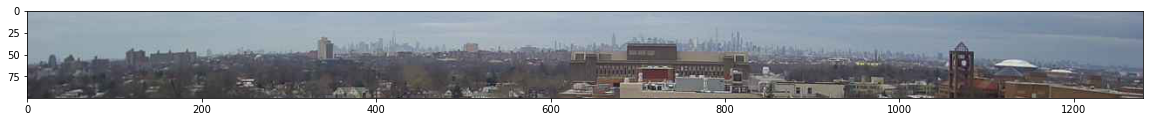

In [4]:
#open an image from a station, where the cam is facing its current direction
import glob
import matplotlib.image as mpimg

STN = 'QUEE'
ASOS = 'JFK'
startdate = dt.datetime.strptime(currentdirs[STN][1], '%Y-%m-%d %H:%M:%S') + dt.timedelta(days=30) #skip some time to ensure cam is running
startdate = dt.datetime.strptime('2019-01-01 13:00:00', '%Y-%m-%d %H:%M:%S')
startdate -= dt.timedelta(minutes=startdate.minute)
IMGDIR = '/tf/NYSM/archive/nysm/cam_photos'
imgsubdir = '{:04d}/{:02d}/{:02d}/{}'.format(startdate.year, startdate.month, startdate.day, STN)
os.chdir(os.path.join(IMGDIR, imgsubdir))
imgfile = glob.glob('{:04d}{:02d}{:02d}T{:02d}{:02d}*'.format(startdate.year, startdate.month, startdate.day, startdate.hour, startdate.minute // 60 * 60))
print(startdate, imgfile)
image = mpimg.imread(imgfile[0])
y0 = 225
y1 = 325
x0 = 0
x1 = 1280
plt.imshow(image[y0:y1, x0:x1, :])

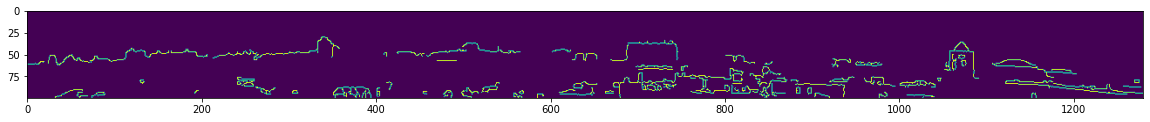

In [7]:
plt.imshow(smartcanny(image[y0:y1, x0:x1, :]))

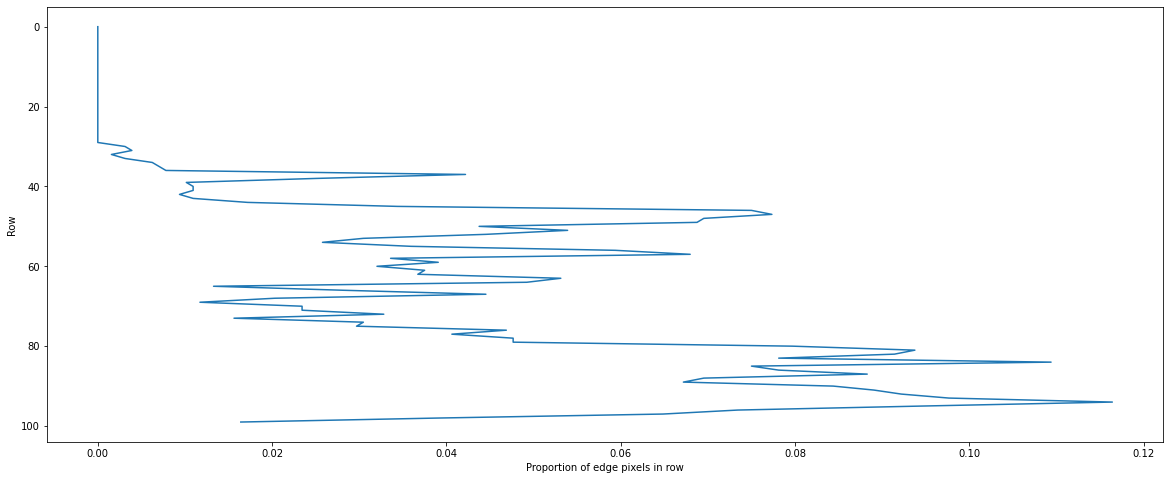

In [8]:
edged = smartcanny(image[y0:y1, x0:x1, :])
rows = np.arange(0, edged.shape[0], 1)
edgebyrow = np.sum(edged, axis = 1) / (255 * edged.shape[1])
plt.plot(edgebyrow, rows)
plt.xlabel('Proportion of edge pixels in row')
plt.ylabel('Row')
plt.gca().invert_yaxis()

In [5]:
#perform Canny edge detection on a few images (partially from my CV bridge project)
#https://gist.github.com/hackintoshrao/0e8da3c3119713621b294c1e6a34640b
#https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
import cv2

def smartcanny(img):
    """
    Canny edge detection with thresholds optimized for the lighting of each image
    
    :rtype: np array representing the edges of the image
    """

    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 5 # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    v = np.median(blur_gray) # compute the median of the single channel pixel intensities
    sigma = 0.33

    # Define our parameters for Canny and run it
    low_threshold = int(max(0, (1.0 - sigma) * v))
    high_threshold = int(min(255, (1.0 + sigma) * v))
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    return edges

In [6]:
def isdaytime(image):
    """
    Returns whether NYSM image was taken in day (color) or night (grayscale) mode.
    :rtype: boolean
    """
    return not (image == cv2.cvtColor(image, cv2.COLOR_RGB2BGR)).all()

In [7]:
def contrast(image):
    """
    Returns the Michelson contrast of an image
    :rtype: float
    """
    
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    Imax = np.amax(gray) #max intensity
    Imin = np.amin(gray)
    
    return (Imax - Imin) / (Imax + Imin)

In [8]:
def contrast2(image, ylim = (0, 720), xlim = (0, 1280)):
    """
    Returns a contrast-based score of an image, calculated based on the max/min first difference of the row-average brightness,
    normalized by the range of brightness over all rows.
    
    :Parameters:
        image (np array of an rgb image)
        ylim (tuple of ints): rows over which to consider brightness gradient
        xlim (tuple of ints): cols over which to consider brightness gradient
    
    :rtype: float
    """

    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    rowavg = np.mean(gray[:, xlim[0]: xlim[1]], axis = 1) #row average brightness with x-limits
    brightgrad = np.diff(rowavg, axis = 0) #vertical gradient of row average
    
    return -1 * np.percentile(brightgrad[ylim[0]: ylim[1]], 10) / (np.amax(rowavg) - np.amin(rowavg))

In [9]:
def DarkChannel(im,sz):
    """
    He et al. 2009
    Returns a grayscale image representing the value of each pixel's darkest channel in the original image.
    
    :Parameters:
        im (np array of bgr image)
        sz (int): side length of the square erode filter
    
    :rtype: np array of a grayscale image
    """
    
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b); #per-element minimum (i.e. the brightness of the darkest channel)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel) #uses the kernel to erode away the boundaries of foreground objects
    return dark

In [10]:
def AtmLight(im,dark):
    """
    He et al. 2009
    Returns a three-element 1D array indicating the atmospheric lighting in each BGR channel
    
    :Parameters:
        im (np array of bgr image): original image
        dark (np array of grayscale image): value of each pixel's darkest channel in the original image.
    
    :rtype: 1D np array
    """
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1)) #number of pixels in 0.1% of the image
    darkvec = dark.reshape(imsz);
    imvec = im.reshape(imsz,3);

    indices = darkvec.argsort();
    indices = indices[imsz-numpx::] #top 0.1% of brightest pixels in dark channel map

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
        atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx;
    return A

In [11]:
def TransmissionEstimate(im,A,sz):
    """
    He et al. 2009
    Returns a grayscale image representing the estimated transmission map
    
    :Parameters:
        im (np array of bgr image): original image
        A (1x3 np array): atmospheric light
        sz (int): side length of the square erode filter
    
    :rtype: np array of a grayscale image
    """
    omega = 0.95;
    im3 = np.empty(im.shape,im.dtype);

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]

    transmission = 1 - omega*DarkChannel(im3,sz);
    return transmission

In [12]:
def transmissionscore(image, sz = 15):
    """
    Returns the average value of the estimated transmission map using He et al.'s (2009) TransmissionEstimate()
    
    :Parameters:
        image (np array of rgb image)
        sz (int): side length of the square erode filter
    
    :rtype: float
    """
    
    bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    I = bgr.astype('float64')/255;

    dark = DarkChannel(I,sz);
    A = AtmLight(I,dark);
    te = TransmissionEstimate(I,A,sz);
    
    return np.median(te)

In [13]:
def transgradscore(image, sz = 15):
    """
    Takes the row-average of the transmission map and returns the value of the greatest magnitude 1st difference.
    Estimated transmission map uses He et al.'s (2009) TransmissionEstimate().
    
    :Parameters:
        image (np array of rgb image)
        sz (int): side length of the square erode filter
    
    :rtype: float
    """
    
    bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    I = bgr.astype('float64')/255;

    dark = DarkChannel(I,sz);
    A = AtmLight(I,dark);
    te = TransmissionEstimate(I,A,sz);
    
    rowavg = np.mean(te, axis = 1)
    transgrad = np.diff(rowavg, axis = 0) #vertical gradient of row average
    
    return abs(max(np.amin(transgrad), np.amax(transgrad), key=abs)) #maybe try greatest positive difference so snow in the foreground doesn't inflate numbers
    #return np.amax(transgrad) #also try normalizing wrt to the range of transmissions in the entire image?

In [14]:
isdaytime(image)

True

In [15]:
#This method is too slow. Maybe a binary search of the chronologically sorted ASOS file
#or requesting data for an entire date range instead of day by day would help.
def getASOSvis(ASOSstn, time):
    """
    From the Iowa State Mesonet website, get the visibility in statute miles of an ASOS station at a particular time
    
    :Parameters:
        ASOSstn (str): IATA or three-char code of ASOS station
        
        time (cftime or datetime object)
    
    :rtype: float
    """

    url = 'https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station={}&data=vsby&year1={}&month1={}&day1={}&year2={}&month2={}&day2={}&tz=Etc%2FUTC&format=onlycomma&latlon=no&elev=no&missing=M&trace=T&direct=no&report_type=1&report_type=2'.format(ASOSstn, time.year, time.month, time.day, time.year, time.month, time.day)
    asosfile = urllib.request.urlopen(url)

    for line in asosfile:
        decoded_line = line.decode("utf-8").split(',')
        try:
            linetime = dt.datetime.strptime(decoded_line[1], '%Y-%m-%d %H:%M')
        except:
            continue
        #print('Visibility: %s miles' % decoded_line[2][:-1] if linetime.hour == time.hour and linetime.minute == time.minute else '', end = '')
        if linetime.hour == time.hour and linetime.minute == time.minute:
            try:
                return float(decoded_line[2][:-1])
            except:
                return np.nan

In [16]:
def getASOSvisseries(ASOSstn, startdate, duration, timestep, logminute = 0):
    #TODO add a minutes argument since not every station logs data on the hour
    """
    From the Iowa State Mesonet website, get the visibility in statute miles of an ASOS station for a time period. Exclusive of startdate + duration.
    
    :Parameters:
        ASOSstn (str): IATA or three-char code of ASOS station
        
        startdate (cftime or datetime object): minute = 0
        
        duration (timedelta object): how long of a time series
        
        timestep (timedelta object): sampling time step of time series
        
        logminute (int in 0..10 or 50..59): which minute of the hour does the ASOS log visibility if not on the hour?
    
    :rtype: list of timestamps (datetime object), list of visibility (floats)
    """

    #if ASOS doesn't log visibility on the hour, use a specified time up to 10 minutes away
    if logminute in range(1, 11):
        startdate += dt.timedelta(minutes = logminute)
    elif logminute in range(50, 60):
        startdate += dt.timedelta(minutes = logminute - 60)
    elif logminute != 0:
        raise ValueError('Desired ASOS measurement time must not be more than 10 minutes from the hour.')
    
    enddate = startdate + duration + dt.timedelta(days = 1)
    
    timestamps = [startdate]
    for i in range(1, duration // timestep):
        timestamps.append(timestamps[i - 1] + timestep)
    
    url = 'https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station={}&data=vsby&year1={}&month1={}&day1={}&year2={}&month2={}&day2={}&tz=Etc%2FUTC&format=onlycomma&latlon=no&elev=no&missing=M&trace=T&direct=no&report_type=1&report_type=2'.format(ASOSstn, startdate.year, startdate.month, startdate.day, enddate.year, enddate.month, enddate.day)
    asosfile = urllib.request.urlopen(url)
    lines = asosfile.readlines()
    print(url)
    
    visibs = []
    timeidx = 0
    for idx in range(1, len(lines)):
        decoded_line = lines[idx].decode("utf-8").split(',')
        linetime = dt.datetime.strptime(decoded_line[1], '%Y-%m-%d %H:%M')
        if linetime > timestamps[-1]:
            break
        if linetime == timestamps[timeidx]: #if the line time matches the next desired time in the time series
            try:
                visibs.append(float(decoded_line[2][:-1]))
                #print(timeidx, len(visibs), timestamps[timeidx], linetime, visibs[-1])
            except ValueError: #if value is M (missing)
                visibs.append(np.nan)
            timeidx += 1
        if timeidx < len(timestamps) - 1 and linetime > timestamps[timeidx]: #if a desired time isn't available in the ASOS, skip ahead
            del(timestamps[timeidx])
            
    return timestamps, visibs

In [17]:
#set up for loop through files
hours = (0, int(2.5 * 365 * 24))
timestamps, meancanny, contrasts, txes = ([], []), ([], []), ([], []), ([], []) #form a time series of Canny, contrast, and transmission scores. Each tuple is night then day.

In [18]:
%%time
#TODO put this into a method like datasetfromASOS.ipynb
import sys
#compute a Canny edge score time series (score is proportion of edge pixels * 255)
for hour in range (*hours): #hours since startdate
    date = cftime.num2date(hour, 'hours since %s' % startdate)
    if date.day == 1 and date.hour == 0:
        print('Working on date %s' % str(date))
    
    imgsubdir = '{:04d}/{:02d}/{:02d}/{}'.format(date.year, date.month, date.day, STN)
    try:
        os.chdir(os.path.join(IMGDIR, imgsubdir))
        imgfile = glob.glob('{:04d}{:02d}{:02d}T{:02d}{:02d}*'.format(date.year, date.month, date.day, date.hour, date.minute // 60 * 60))
        image = mpimg.imread(imgfile[0])
        isday = isdaytime(image) & 1 | 0
        timestamps[isday].append(date)
        meancanny[isday].append(np.mean(smartcanny(image[y0:y1, x0:x1, :])) / 255.)
        #visibs[isday].append(getASOSvis(ASOS, date))
        contrasts[isday].append(10 * contrast2(image, ylim = (y0, y1), xlim = (x0, x1))) #(contrast(image[y0:y1, x0:x1, :]))
        txes[isday].append(transmissionscore(image[y0:y1, x0:x1, :]))
    except:
        None

Working on date 2019-02-01 00:00:00
Working on date 2019-03-01 00:00:00
Working on date 2019-04-01 00:00:00
Working on date 2019-05-01 00:00:00
Working on date 2019-06-01 00:00:00
Working on date 2019-07-01 00:00:00
Working on date 2019-08-01 00:00:00
Working on date 2019-09-01 00:00:00
Working on date 2019-10-01 00:00:00
Working on date 2019-11-01 00:00:00
Working on date 2019-12-01 00:00:00
Working on date 2020-01-01 00:00:00
Working on date 2020-02-01 00:00:00
Working on date 2020-03-01 00:00:00
Working on date 2020-04-01 00:00:00
Working on date 2020-05-01 00:00:00
Working on date 2020-06-01 00:00:00
Working on date 2020-07-01 00:00:00
Working on date 2020-08-01 00:00:00
Working on date 2020-09-01 00:00:00
Working on date 2020-10-01 00:00:00
Working on date 2020-11-01 00:00:00
Working on date 2020-12-01 00:00:00
Working on date 2021-01-01 00:00:00
Working on date 2021-02-01 00:00:00
Working on date 2021-03-01 00:00:00
Working on date 2021-04-01 00:00:00
Working on date 2021-05-01 0

In [19]:
#get ASOS visibility time series
vistimestamps, visibs = getASOSvisseries(ASOS, startdate, dt.timedelta(hours = hours[1]), dt.timedelta(hours = 1), logminute = 51)
vistimestamps = [time + dt.timedelta(minutes = 9) for time in vistimestamps]
print(len(vistimestamps), len(visibs))
print(vistimestamps[192], visibs[192])

https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=JFK&data=vsby&year1=2019&month1=1&day1=1&year2=2021&month2=7&day2=3&tz=Etc%2FUTC&format=onlycomma&latlon=no&elev=no&missing=M&trace=T&direct=no&report_type=1&report_type=2
21815 21815
2019-01-09 13:00:00 10.0


20877 20793


Text(0.5, 1.0, 'JFK Visibility')

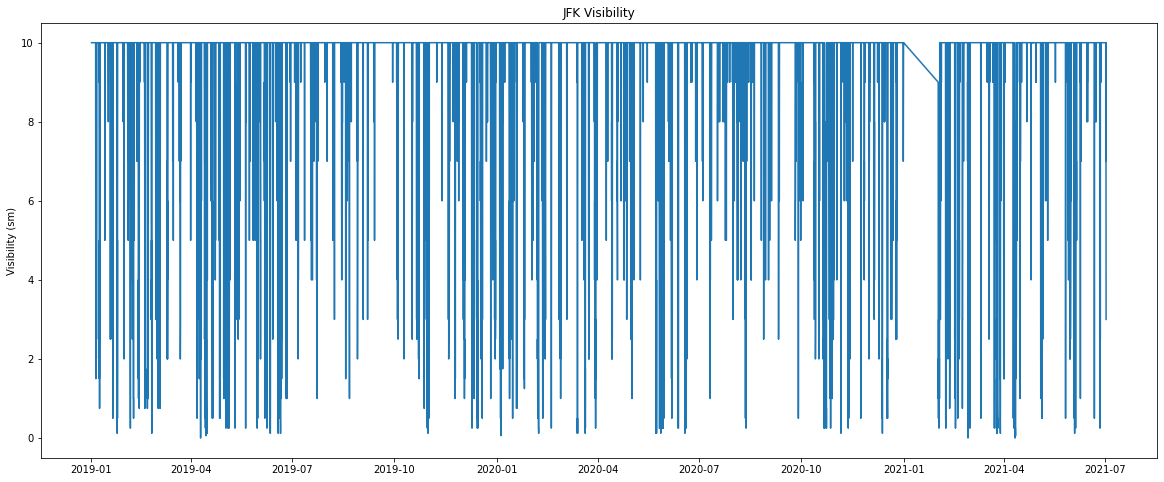

In [20]:
#separate visibility time series into day mode and night mode, eliminating times when no image is available
visdaynighttimes, visibdaynight = ([], []), ([], [])
daynightsets = (set(timestamps[0]), set(timestamps[1]))
for idx in range(len(visibs)):
    if vistimestamps[idx] in daynightsets[0]:
        visdaynighttimes[0].append(vistimestamps[idx])
        visibdaynight[0].append(visibs[idx])
    if vistimestamps[idx] in daynightsets[1]:
        visdaynighttimes[1].append(vistimestamps[idx])
        visibdaynight[1].append(visibs[idx])
print(len(timestamps[1]), len(visibdaynight[1]))
visdaynighttimes = (np.array(visdaynighttimes[0]), np.array(visdaynighttimes[1]))
visibdaynight = (np.array(visibdaynight[0]), np.array(visibdaynight[1]))

plt.plot(visdaynighttimes[1], visibdaynight[1])
plt.ylabel("Visibility (sm)")
plt.title("%s Visibility" % ASOS)

In [21]:
#filter out images for which a visib measurement was logged by the ASOS
daynightsets = (set(visdaynighttimes[0]), set(visdaynighttimes[1]))
newtimes, newcanny, newcontrasts, newtxes = ([], []), ([], []), ([], []), ([], [])
for i in range(2):
    for idx in range(len(timestamps[i])):
        if timestamps[i][idx] in daynightsets[i]:
            #print(timestamps[i][idx])
            newtimes[i].append(timestamps[i][idx])
            newcanny[i].append(meancanny[i][idx])
            newcontrasts[i].append(contrasts[i][idx])
            newtxes[i].append(txes[i][idx])
'''newtimes = (newtimes[0][:len(newtimes[0]) // 2], newtimes[1][:len(newtimes[1]) // 2]) #for some reason, lists are duplicated like [a, b, c, a, b, c]
newcanny = (newcanny[0][:len(newcanny[0]) // 2], newcanny[1][:len(newcanny[1]) // 2])
newcontrasts = (newcontrasts[0][:len(newcontrasts[0]) // 2], newcontrasts[1][:len(newcontrasts[1]) // 2])'''
print(len(newcanny[0]), len(visibdaynight[0]))

0 0


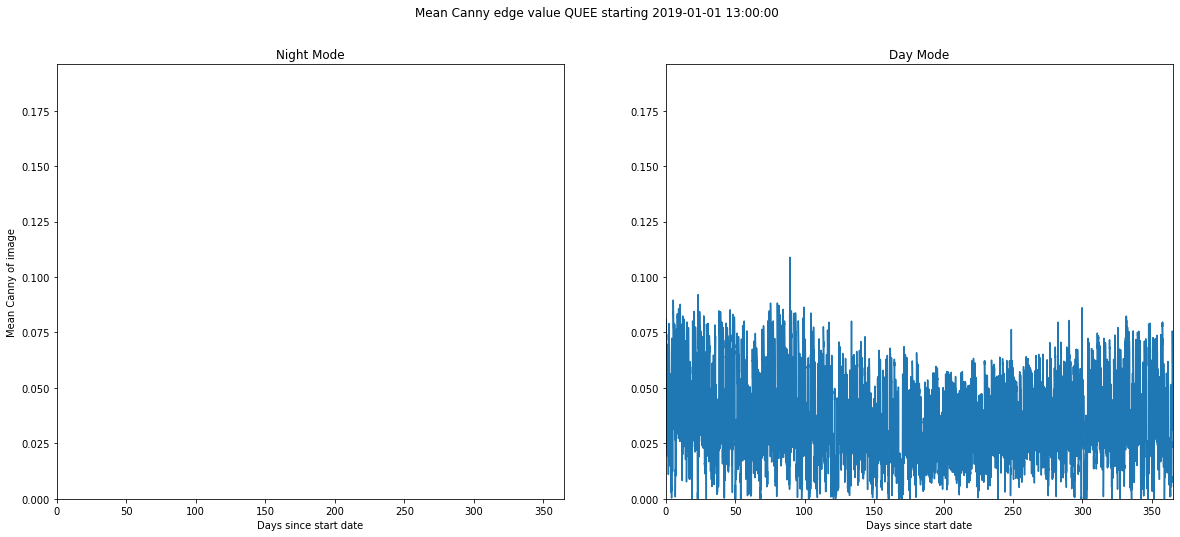

In [22]:
#plot time series of Canny scores
#print([fname[:-9] for fname in timestamps])
#print(timestamps)
plottimes = ([cftime.date2num(d, 'days since %s' % startdate, calendar = 'standard') for d in timestamps[0]], \
             [cftime.date2num(d, 'days since %s' % startdate, calendar = 'standard') for d in timestamps[1]]) #accounted for the fact that I only take full-hour images?
#print(plottimes)
fig, axes = plt.subplots(1, 2)
axes[0].plot(plottimes[0], meancanny[0])
axes[1].plot(plottimes[1], meancanny[1])
axes[0].title.set_text('Night Mode')
axes[1].title.set_text('Day Mode')
fig.suptitle("Mean Canny edge value %s starting %s" % (STN, str(startdate - dt.timedelta(minutes=startdate.minute)))) #note that startdate is actually the previous hour mark
[axes[i].set(xlabel = 'Days since start date', xlim = (0, 365), ylim = (0, 50 / 255)) for i in range(len(axes))]
axes[0].set(ylabel = 'Mean Canny of image')
plt.rcParams['figure.figsize'] = [15, 8]

0.108890625
0.0
0.2070745868691365


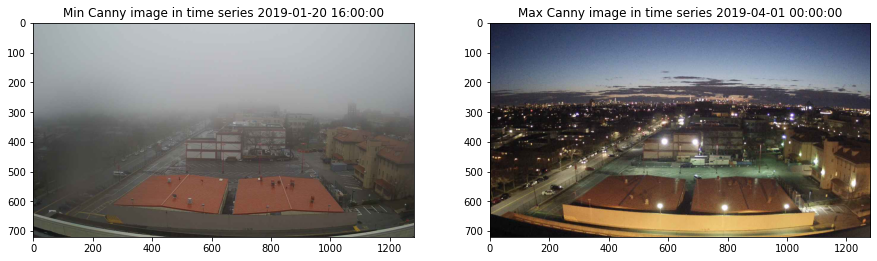

In [23]:
#show min and max Canny scores and their associated images
cannyarray = (np.array(meancanny[0]), np.array(meancanny[1]))
x = 1 #0 for night, 1 for day
maxcanny = timestamps[x][np.argmax(cannyarray[x])]
mincanny = timestamps[x][np.argmin(cannyarray[x])]
print(cannyarray[x][np.argmax(cannyarray[x])])
print(cannyarray[x][np.argmin(cannyarray[x])])
#print(mincanny, maxcanny)
minsubdir = '{:04d}/{:02d}/{:02d}/{}'.format(mincanny.year, mincanny.month, mincanny.day, STN)
maxsubdir = '{:04d}/{:02d}/{:02d}/{}'.format(maxcanny.year, maxcanny.month, maxcanny.day, STN)

os.chdir(os.path.join(IMGDIR, minsubdir))
minimgfile = glob.glob('{:04d}{:02d}{:02d}T{:02d}{:02d}*'.format(mincanny.year, mincanny.month, mincanny.day, mincanny.hour, mincanny.minute // 60 * 60))
minimg = mpimg.imread(minimgfile[0])

os.chdir(os.path.join(IMGDIR, maxsubdir))
maximgfile = glob.glob('{:04d}{:02d}{:02d}T{:02d}{:02d}*'.format(maxcanny.year, maxcanny.month, maxcanny.day, maxcanny.hour, maxcanny.minute // 60 * 60))
maximg = mpimg.imread(maximgfile[0])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(minimg)
axes[1].imshow(maximg)
plt.rcParams['figure.figsize'] = [20, 8]
axes[0].title.set_text('Min Canny image in time series % s' % str(mincanny - dt.timedelta(minutes=mincanny.minute))) #note that image is actually the previous hour mark
axes[1].title.set_text('Max Canny image in time series %s' % str(maxcanny - dt.timedelta(minutes=maxcanny.minute)))

print(transmissionscore(minimg[y0:y1, x0:x1, :]))

In [ ]:
#Canny score is the proportion of edge pixels in cropped region, found by applying a thresholded Canny
fig, axes = plt.subplots(1, 2)
[axes[i].hist(cannyarray[i], bins = 10, density = True) for i in range(len(axes))]
[axes[i].set(xlabel = 'Canny score', xlim = (0, 50 / 255), ylim = (0, 10)) for i in range(len(axes))]
axes[0].set(ylabel = "Density (relative freq / bin width)")
axes[0].title.set_text('Night Mode')
axes[1].title.set_text('Day Mode')
fig.suptitle("Canny Score Distributions %s starting %s" % (STN, str(startdate - dt.timedelta(minutes=startdate.minute)))) #note that startdate is actually the previous hour mark

In [ ]:
timestamps[0][np.where(cannyarray[1] < 1)[0][0]]

In [ ]:
#select a random image from a percentile range in the canny distro
x = 1
cannyseries = meancanny[x]
pctile2 = np.percentile(cannyseries, 15)
pctile1 = np.percentile(cannyseries, 0)
#print(pctile1)
idxs = np.where((cannyseries >= pctile1) & (cannyseries <= pctile2))[0]
print(len(idxs) / len(cannyseries), len(cannyseries))
seldate = timestamps[x][np.random.choice(idxs)]
imgsubdir = '{:04d}/{:02d}/{:02d}/{}'.format(seldate.year, seldate.month, seldate.day, STN)
os.chdir(os.path.join(IMGDIR, imgsubdir))
imgfile = glob.glob('{:04d}{:02d}{:02d}T{:02d}{:02d}*'.format(seldate.year, seldate.month, seldate.day, seldate.hour, seldate.minute // 60 * 60))
print(seldate, imgfile)
image = mpimg.imread(imgfile[0])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(smartcanny(image[y0:y1, x0:x1, :]))
axes[1].imshow(image)
print(isdaytime(image))
#print(pctile2)

In [ ]:
#select a random image from a percentile range in the contrast distro
x = 1
contrastseries = np.array(contrasts[x])
pctile2 = np.percentile(contrastseries, 5)
pctile1 = np.percentile(contrastseries, 0)
#print(pctile1, pctile2)
idxs = np.where((contrastseries >= pctile1) & (contrastseries <= pctile2))[0]
print(len(idxs) / len(contrastseries), len(contrastseries))
seldate = timestamps[x][np.random.choice(idxs)]
imgsubdir = '{:04d}/{:02d}/{:02d}/{}'.format(seldate.year, seldate.month, seldate.day, STN)
os.chdir(os.path.join(IMGDIR, imgsubdir))
imgfile = glob.glob('{:04d}{:02d}{:02d}T{:02d}{:02d}*'.format(seldate.year, seldate.month, seldate.day, seldate.hour, seldate.minute // 60 * 60))
print(seldate, imgfile)
image = mpimg.imread(imgfile[0])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(image[y0:y1, x0:x1, :])
axes[1].imshow(image)
print(contrast2(image))
#print(isdaytime(image))
#print(pctile2)

In [ ]:
#print visibility measurement from nearby ASOS station
import urllib

url = 'https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station={}&data=vsby&year1={}&month1={}&day1={}&year2={}&month2={}&day2={}&tz=Etc%2FUTC&format=onlycomma&latlon=no&elev=no&missing=M&trace=T&direct=no&report_type=1&report_type=2'.format(ASOS, seldate.year, seldate.month, seldate.day, seldate.year, seldate.month, seldate.day)
print(url)
asosfile = urllib.request.urlopen(url)

for line in asosfile:
    decoded_line = line.decode("utf-8").split(',')
    #print(decoded_line)
    try:
        linetime = dt.datetime.strptime(decoded_line[1], '%Y-%m-%d %H:%M')
        #print(linetime)
        print('Visibility: %s miles' % decoded_line[2][:-1] if linetime.hour == seldate.hour and linetime.minute == seldate.minute else '', end = '')
    except:
        None

In [ ]:
#plot a scatter of cropped Canny score vs. visibility
x = 1
plt.scatter(visibdaynight[x], newcanny[x])
plt.title("%s Canny Score vs. %s Visibility starting %s" % (STN, ASOS, str(startdate - dt.timedelta(minutes=startdate.minute))))
plt.xlabel("ASOS visibility (sm)")
plt.ylabel("Cropped Canny score")

In [ ]:
#plot a scatter of cropped contrast vs. visibility
plt.scatter(visibdaynight[x], newcontrasts[x])
plt.title("%s Contrast score vs. %s Visibility starting %s" % (STN, ASOS, str(startdate - dt.timedelta(minutes=startdate.minute))))
plt.xlabel("ASOS visibility (sm)")
plt.ylabel("Contrast score")

In [ ]:
#plot a scatter of cropped transmission score vs. visibility
plt.scatter(visibdaynight[x], newtxes[x])
plt.title("%s Transmission Score vs. %s Visibility starting %s" % (STN, ASOS, str(startdate - dt.timedelta(minutes=startdate.minute))))
plt.xlabel("ASOS visibility (sm)")
plt.ylabel("Transmission score")

'''from scipy.stats import pearsonr
print(np.amax(visibdaynight[x]))
print(pearsonr(visibdaynight[x], newtxes[x]))'''

In [ ]:
#plot Canny score histograms for different visibilities
#print(len(set(visibs[x])))
sel_vis = 10
sel_vis_idxs = np.where(np.array(visibdaynight[x]) == sel_vis)
plt.rcParams['figure.figsize'] = [12, 8]
plt.hist(np.array(newcanny[x])[sel_vis_idxs], bins = 20, density = True)
plt.title("%s %s Canny Score for %s Visibility = %f miles starting %s" % (STN, 'Day' if x == 1 else 'Night', ASOS, sel_vis, str(startdate - dt.timedelta(minutes=startdate.minute))))
plt.ylabel("Density (rel freq / bin width)")
plt.xlabel("Canny score")
plt.xlim(0, .2)

In [ ]:
#plot Michelson contrast histograms for different visibilities
#print(len(set(visibs[x])))
sel_vis_idxs = np.where(np.array(visibdaynight[x]) == sel_vis)
plt.rcParams['figure.figsize'] = [12, 8]
plt.hist(np.array(newcontrasts[x])[sel_vis_idxs], bins = 10, density = True)
plt.title("%s %s Contrast Score for %s Visibility = %f miles starting %s" % (STN, 'Day' if x == 1 else 'Night', ASOS, sel_vis, str(startdate - dt.timedelta(minutes=startdate.minute))))
plt.ylabel("Density (rel freq / bin width)")
plt.xlabel("Contrast score")
plt.xlim(0, .10)

In [ ]:
#plot transmission score histograms for different visibilities
#print(len(set(visibs[x])))
sel_vis_idxs = np.where(np.array(visibdaynight[x]) == sel_vis)
plt.rcParams['figure.figsize'] = [12, 8]
plt.hist(np.array(newtxes[x])[sel_vis_idxs], bins = 10, density = True)
plt.title("%s %s Transmission Scores for %s Visibility = %f miles starting %s" % (STN, 'Day' if x == 1 else 'Night', ASOS, sel_vis, str(startdate - dt.timedelta(minutes=startdate.minute))))
plt.ylabel("Density (rel freq / bin width)")
plt.xlabel("Transmission Score")
plt.xlim(0, 1)

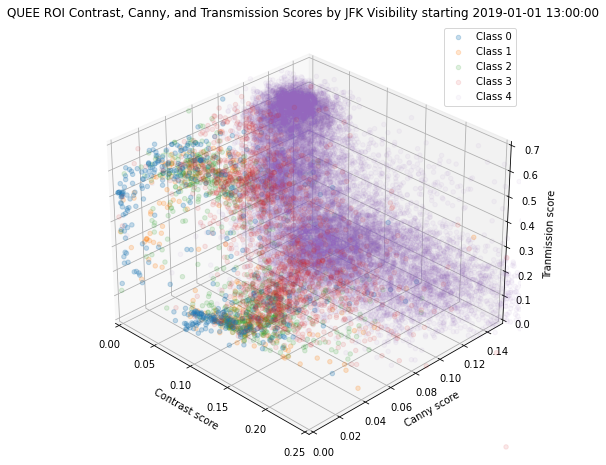

In [31]:
#plot different visibilities in a 3D contrast-Canny-transmission space
#%matplotlib widget
sel_vises = list(range(5)) #these are just class labels
#[10, 9, 8, 7, 6, 5, 4, 3, 2.5, 2, 1.75, 1.5, 1.25, 1, .75, .5, .25, .125] #[10, 4, 1, .25]
#sel_vis_idxs = [np.where(np.array(visibdaynight[x]) == vis) for vis in sel_vises]

sel_vis_idxs = [np.where(np.array(visibdaynight[x]) <= 0.5)]
sel_vis_idxs.append(np.where((np.array(visibdaynight[x]) > 0.5) & (np.array(visibdaynight[x]) <= 1.5)))
sel_vis_idxs.append(np.where((np.array(visibdaynight[x]) <= 4) & (np.array(visibdaynight[x]) > 1.5)))
sel_vis_idxs.append(np.where((np.array(visibdaynight[x]) < 10) & (np.array(visibdaynight[x]) > 4)))
sel_vis_idxs.append(np.where(np.array(visibdaynight[x]) >= 10))

plt.rcParams['figure.figsize'] = [20, 8]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
[ax.scatter(np.array(newcontrasts[x])[idxs], np.array(newcanny[x])[idxs], np.array(newtxes[x])[idxs], label = 'Class %d' % sel_vises[i], alpha = 1 / 20 * (5 - i)) for i, idxs in enumerate(sel_vis_idxs)]
plt.legend()
plt.xlabel("Contrast score")
plt.ylabel("Canny score")
ax.set_zlabel("Tranmission score")
plt.title("%s ROI Contrast, Canny, and Transmission Scores by %s Visibility starting %s" % (STN, ASOS, str(startdate - dt.timedelta(minutes=startdate.minute))))
plt.xlim(0, 0.25)
plt.ylim(0, .15)
ax.set_zlim(0, 0.7)
ax.view_init(30, 315)

In [ ]:
#select a random image that fits criteria in all three of the contrast, Canny, and transmission distros
x = 1
contrastseries = np.array(contrasts[x])
contpctile2 = np.percentile(contrastseries, 10)
contpctile1 = np.percentile(contrastseries, 0)
cannyseries = meancanny[x]
cannypctile2 = np.percentile(cannyseries, 10)
cannypctile1 = np.percentile(cannyseries, 0)
txseries = txes[x]
txpctile2 = np.percentile(txseries, 10)
txpctile1 = np.percentile(txseries, 0)
print('Contrast percentiles:', contpctile1, contpctile2)
print('Canny percentiles:', cannypctile1, cannypctile2)
print('Transmission percentiles:', txpctile1, txpctile2)
contidxs = np.where((contrastseries >= contpctile1) & (contrastseries <= contpctile2))[0]
cannyidxs = np.where((cannyseries >= cannypctile1) & (cannyseries <= cannypctile2))[0]
txidxs = np.where((txseries >= txpctile1) & (txseries <= txpctile2))[0]
sharedidxs = np.intersect1d(contidxs, cannyidxs)
sharedidxs = np.intersect1d(sharedidxs, txidxs)
print(len(sharedidxs) / len(contrastseries), len(contrastseries))
seldate = timestamps[x][np.random.choice(sharedidxs)]
imgsubdir = '{:04d}/{:02d}/{:02d}/{}'.format(seldate.year, seldate.month, seldate.day, STN)
os.chdir(os.path.join(IMGDIR, imgsubdir))
imgfile = glob.glob('{:04d}{:02d}{:02d}T{:02d}{:02d}*'.format(seldate.year, seldate.month, seldate.day, seldate.hour, seldate.minute // 60 * 60))
print(seldate, imgfile)
image = mpimg.imread(imgfile[0])

plt.rcParams['figure.figsize'] = [20, 8]
fig, axes = plt.subplots(1, 2)
axes[0].imshow(image[y0:y1, x0:x1, :])
axes[1].imshow(image)
print(contrast2(image))
#print(isdaytime(image))
#print(pctile2)

In [ ]:
#save time series of vis, Canny, contrast, and tx to a pickle file
import pickle

with open('/tf/visibility/x.pickle', 'wb') as f:
    pickle.dump((y0, y1, x0, x1), f)
    pickle.dump(newtimes, f)
    pickle.dump(visibdaynight, f)
    pickle.dump(newcanny, f)
    pickle.dump(newcontrasts, f)
    pickle.dump(newtxes, f)

In [ ]:
with open('/tf/visibility/20170518T180022_1yr_QUEE_JFK.pickle', 'rb') as f:
    pickle.load(f)
    [print(pickle.load(f)[1][0]) for _ in range(5)]

In [77]:
#Make a dataset where the input vector is in the 3D feature space, and output is a vis class

import pickle

x = 1
feat_vecs, vis_class, vec_times = [], [], []
for i, vis in enumerate(sel_vises[::-1]):
    #sel_vis_idxs = np.where(np.array(visibdaynight[x]) == vis)[0]
    current_idxs = sel_vis_idxs[i]
    for selidx in current_idxs[0]: #sel_vis_idxs:
        #print(selidx)
        feat_vecs.append([newcontrasts[x][selidx],
                          newcanny[x][selidx], newtxes[x][selidx]])
        vec_times.append([newtimes[x][selidx]])
        vis_class.append(i)
print(feat_vecs[-20:],'\n', vis_class[-20:])

with open('/tf/visibility/CCT/0721_DS2.pickle', 'ab') as f:
    pickle.dump(feat_vecs, f)
    pickle.dump(vis_class, f)
    pickle.dump(vec_times, f)

[[0.1788944575326695, 0.008640624999999999, 0.7138528227887299], [0.18411779842144232, 0.011078125, 0.7321932892861767], [0.16095397255787702, 0.010598958333333333, 0.7056763925729442], [0.17143457453017483, 0.012942708333333334, 0.7105517151428189], [0.1572878109388352, 0.00890625, 0.743894280404708], [0.13631087662337715, 0.009546875, 0.7378503233754234], [0.21031329453812722, 0.01309375, 0.6976299634781254], [0.20732660970364633, 0.020958333333333336, 0.7674354099094058], [0.1920130273656331, 0.010583333333333333, 0.7316293929712456], [0.20961305494192256, 0.012760416666666666, 0.6547538323938682], [0.20611953544005845, 0.018567708333333332, 0.6963595741884607], [0.1714955701424023, 0.013307291666666667, 0.6704404065291037], [0.1488588107204698, 0.009166666666666667, 0.636735448105944], [0.17131735070087756, 0.017869791666666666, 0.6479704342469972], [0.1841504939463359, 0.013098958333333334, 0.715380351093317], [0.21263080266605555, 0.011927083333333333, 0.7390840720431735], [0.223